# Exp 14.Movielens 영화 추천

---

# 🗼목차
Step 1. 데이터 준비와 전처리  
Step 2. 데이터 탐색  
Step 3. 선호하는 영화 5가지 고르기  
Step 4. indexing 작업  
Step 5. CSR Matrix 만들기  
Step 6. als 모델 구성 및 훈련  
Step 7. 모델이 예측한 나의 선호도 파악  
Step 8. 내가 좋아하는 영화와 비슷한 영화 추천  
Step 9. 내가 좋아할만한 영화 추천  
🌞 회고

---

# Step 1. 데이터 준비와 전처리

## 1.1 데이터 준비
* Movielens 데이터는 `rating.dat`안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 정리되어 있다.

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']

ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)

ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1.2 데이터 전처리
* 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정한다.
* `ratings`가 3점 이상인 데이터만 남기고 제거한다.
* 필터를 거친 데이터의 사이즈는 `836478`로 필터 전 데이터의 `83.63%`에 해당하는 데이터이다.

In [2]:
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


* 컬럼 이름을 `ratings` → `counts`로 변경한다.

In [3]:
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [4]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [5]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
ratings.tail()

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


* 영화 제목을 보기 위해 메타 데이터를 읽어온다.

In [7]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


* `ratings`데이터와 `movies`데이터를 합쳐보자.
* [데이터프레임 합치기](https://yganalyst.github.io/data_handling/Pd_12/#3-%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84-%EA%B2%B0%ED%95%A9--join)

In [8]:
ratings = pd.merge(ratings, movies, how = 'left', on = 'movie_id')
ratings

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),Drama|War
836474,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
836476,6040,1096,4,956715648,Sophie's Choice (1982),Drama


* `timestamp` 컬럼과 `genre` 컬럼은 필요하지 않으므로 제거하자
* [데이터프레임 열 삭제](https://blog.naver.com/rising_n_falling/221631637822)

In [9]:
ratings = ratings.drop(['timestamp', 'genre', 'movie_id'], axis = 1)
ratings

,user_id,counts,title
0,1,5,One Flew Over the Cuckoo's Nest (1975)
1,1,3,James and the Giant Peach (1996)
2,1,3,My Fair Lady (1964)
3,1,4,Erin Brockovich (2000)
4,1,5,"Bug's Life, A (1998)"
...,...,...,...
836473,6040,3,Platoon (1986)
836474,6040,5,"Crying Game, The (1992)"
836475,6040,5,Welcome to the Dollhouse (1995)
836476,6040,4,Sophie's Choice (1982)


---

# Step 2. 데이터 탐색
* 데이터의 기본적인 정보를 살펴보자.

## 2.1 unique한 영화, 유저 수

In [10]:
print('영화 종류 : ', ratings['title'].nunique())
print('유저 수 : ', ratings['user_id'].nunique())

영화 종류 :  3628
유저 수 :  6039


## 2.2 가장 인기 있는 영화

In [11]:
movie_count = ratings.groupby('title')['user_id'].count()
movie_count.sort_values(ascending = False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

## 2.3 유저 별 시청한 영화 통계
* 영화를 1편만 시청한 유저가 있으며, 1968편의 영화를 시청한 유저가 있다.
* 평균적으로 유저들은 138편의 영화를 시청하였다.

In [12]:
user_count = ratings.groupby('user_id')['title'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

---

# Step 3. 선호하는 영화 5가지 고르기
* 모델 검증을 위해 유저 초기 정보를 셋팅하는 작업이다.
* 서비스에 처음 가입하는 사용자의 취향과 유사한 항목을 입력하도록 하는 과정이라고 생각하면 된다.

* 원하는 영화를 편하게 찾기 위해 title을 소문자로 변경하였다.
* 이 아이디어는 [이전 기수 우수프로젝트](https://github.com/thk-lightman/Proj_AIFFEL-LMS/blob/master/%5BE-09%5D%20Recommend%20Movies.ipynb)에서 참고하였다.

In [13]:
low_title = ratings['title'].str.lower()

* 원하는 영화 키워드를 입력해서 있는지 찾아보았다.
* [데이터프레임에서 특정 문자열을 포함하는 행 추출하기](https://zephyrus1111.tistory.com/46)

In [14]:
ratings[low_title.str.contains('titanic')]

,user_id,counts,title
27,1,4,Titanic (1997)
557,8,5,Titanic (1997)
672,9,5,Titanic (1997)
1027,10,3,Titanic (1997)
1934,18,4,Titanic (1997)
...,...,...,...
834500,6025,4,Titanic (1997)
834642,6027,4,Titanic (1997)
834958,6033,5,Titanic (1953)
835385,6036,3,"Chambermaid on the Titanic, The (1998)"


* 내가 좋아하는 영화 5개를 입력해보자.
* 2개는 디즈니 애니메이션, 3개는 드라마/로맨스 장르의 영화로 선택하였다.

In [15]:
my_favorite = ['Lion King, The (1994)', 'Toy Story (1995)', 'Before Sunrise (1995)', 'Notting Hill (1999)', 'Forrest Gump (1994)']

my_movielist = pd.DataFrame({'user_id' : ['6041']*5, 'title': my_favorite, 'counts' : [5]*5})

if not ratings.isin({'user_id' : ['6041']})['user_id'].any():
    ratings = ratings.append(my_movielist)
    
ratings.tail(10)

,user_id,counts,title
836473,6040,3,Platoon (1986)
836474,6040,5,"Crying Game, The (1992)"
836475,6040,5,Welcome to the Dollhouse (1995)
836476,6040,4,Sophie's Choice (1982)
836477,6040,4,E.T. the Extra-Terrestrial (1982)
0,6041,5,"Lion King, The (1994)"
1,6041,5,Toy Story (1995)
2,6041,5,Before Sunrise (1995)
3,6041,5,Notting Hill (1999)
4,6041,5,Forrest Gump (1994)


---

# Step 4. indexing 작업
* 고유한 `user`와 `movie` 각각에 번호를 붙이는 indexing 작업이다.

In [16]:
user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [17]:
print(user_to_idx['6041'])      # 고유한 유저의 수인 6039명 중 마지막 추가 유저이므로 인덱스 6039임
print(movie_to_idx['Toy Story (1995)'])

6039
40


* indexing을 통해 데이터 컬럼 내 값을 바꾼다.
* 정상적으로 인덱싱이 되지 않은 row가 있을 수 있는데, 이 때 인덱스가 NaN이 될 것이니 `dropna()`로 제거한다.

In [18]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()

if len(temp_user_data) == len(ratings): 
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!!')

temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

ratings

user_id column indexing OK!!
movie column indexing OK!!


,user_id,counts,title
0,0,5,0
1,0,3,1
2,0,3,2
3,0,4,3
4,0,5,4
...,...,...,...
0,6039,5,330
1,6039,5,40
2,6039,5,213
3,6039,5,1151


---

# Step 5. CSR Matrix 만들기
* CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조
* data, indices, indptr로 행렬을 압축하여 표현

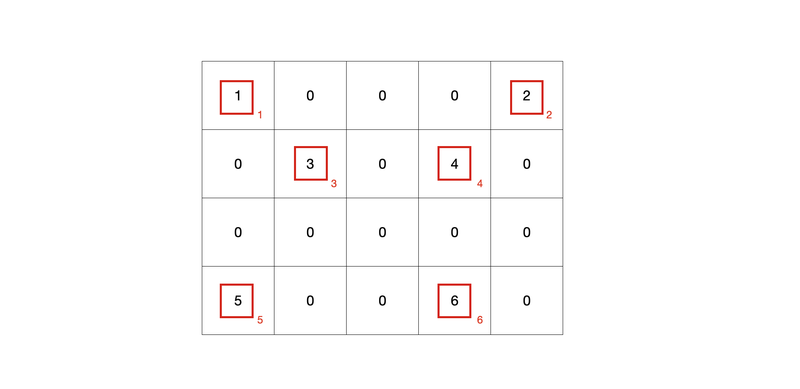

* data : 0이 아닌 원소를 차례로 기입한 값이다.
* indices : data의 각 요소가 어느 열(column)에 있는지를 표현한 index이다.
* indptr : 각 행(row)에서 0이 아닌 첫 번째 원소가 data 리스트에서 몇 번째에 해당하는지와 마지막에 data 벡터의 길이를 추가한 값이다. 이를 통해 data의 요소들이 어느 행(row)에 있는지 알 수 있다. 0이 아닌 원소가 없는 경우, 그 다음 행의 값과 같은 값을 넣는다.

>data = [1, 2, 3, 4, 5, 6]  
indices = [0, 4, 1, 3, 0, 3]  
indptr = [0, 2, 4, 4, 6]
    
* 이를 통해 data[0:2]는 첫 번째 행, data [2:4]는 두 번째 행, data[4:4]는 세번째 행, data[4:6]는 네 번째 행에 위치함을 나타낼 수 있게 된다.

* data를 `CSR Matrix`에 맞게 바꿔보자.
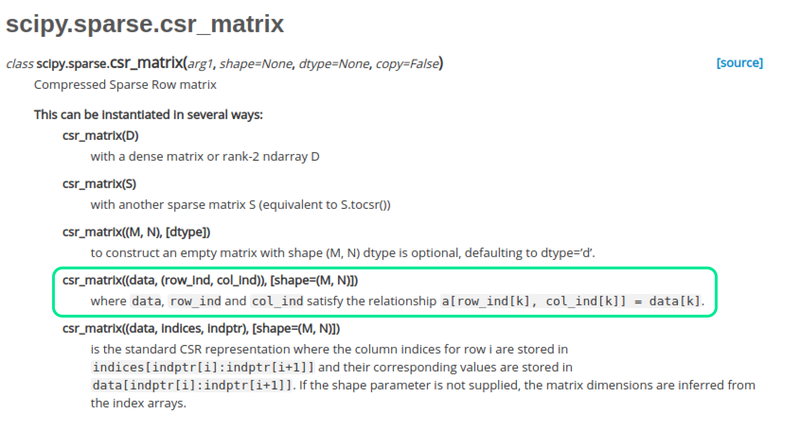

In [19]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

csr_ratings = csr_matrix((ratings.counts, (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_ratings

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

---

# Step 6. als 모델 구성 및 훈련
* `Matrix Factorization 모델`을 `implicit 패키지`를 사용해서 학습해보자.
* `implicit` 패키지는 이전 스텝에서 설명한 암묵적 dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지다.
* 이 패키지의 `als(AlternatingLeastSquares) 모델`을 사용한다. 
* `Matrix Factorization`에서 쪼개진 두 Featrue Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않는다.
* 그래서 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 `AlternatingLeastSquares` 방식이 효과적인 것으로 알려져있다.

In [20]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

*  `AlternatingLeastSquares` 클래스의 __init__ 파라미터
    * factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
    * regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
    * use_gpu : GPU를 사용할 것인지
    * iterations : epochs와 같은 의미 (데이터를 몇 번 반복해서 학습할 것인지)

In [21]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=50, dtype=np.float32)

In [22]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_ratings_transpose = csr_ratings.T
csr_ratings_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [23]:
# 모델 훈련
als_model.fit(csr_ratings_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

---

# Step 7. 모델이 예측한 나의 선호도 파악
* 내가 선호하는 5가지 영화 중 하나와 그 외 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보자.

In [24]:
ram = user_to_idx['6041']
ram_vector = als_model.user_factors[ram]

In [25]:
ram_vector

array([ 2.23466784e-01, -5.24722219e-01,  2.43393153e-01, -2.68363088e-01,
        6.67052984e-01,  5.71467221e-01,  3.39486569e-01,  2.01442301e-01,
       -2.50274837e-01, -2.85649784e-02,  2.10988641e-01, -7.95118064e-02,
        4.26127225e-01,  2.18086660e-01,  2.14625299e-01, -5.89419186e-01,
        6.29487872e-01,  1.73880726e-01,  1.70581773e-01,  5.59604645e-01,
       -1.28214687e-01,  1.96740441e-02, -6.80616917e-03,  1.68854132e-01,
       -2.88751330e-02,  6.16470218e-01, -1.20033868e-01,  3.53649288e-01,
        6.09018028e-01,  2.34986637e-02,  4.85929623e-02, -3.53705168e-01,
        1.52940258e-01, -2.90512983e-02, -4.55225438e-01, -1.34981558e-01,
       -2.52410501e-01, -1.53925911e-01, -4.28757221e-01, -4.31377679e-01,
       -3.51973772e-01, -3.51306908e-02, -1.94842920e-01,  1.58254027e-01,
        4.82885450e-01,  6.48343638e-02,  5.07110000e-01, -7.35496357e-03,
       -1.07508592e-01, -8.23037401e-02,  4.81240511e-01, -3.16917419e-01,
        2.06879270e-03,  

## 7.1 내가 선호하는 영화

* `ram`과 `Toy_Story`를 내적하여 나오는 값을 확인해보자.
* 1이 나오면 좋은데, `0.58` 정도 나왔다.

In [26]:
Toy_Story = movie_to_idx['Toy Story (1995)']
Toy_Story_vector = als_model.item_factors[Toy_Story]

In [27]:
Toy_Story_vector

array([ 0.0185046 , -0.00187103,  0.0083031 , -0.00938825,  0.03811704,
        0.02358048,  0.0043061 ,  0.00528527, -0.04296726,  0.02020213,
        0.01277742, -0.04255804, -0.0209618 ,  0.02739021,  0.00295607,
        0.0005859 ,  0.02369058,  0.044634  , -0.00044994,  0.0245046 ,
        0.03274077,  0.01504953,  0.04358787,  0.01315746,  0.01980648,
        0.02827902,  0.03510115,  0.00039078,  0.05443075,  0.02561811,
        0.00985536, -0.00432733, -0.0119912 ,  0.00555213, -0.03993578,
        0.01111121, -0.02688155, -0.01775103, -0.00661083, -0.0151035 ,
        0.00088102,  0.0356894 ,  0.0262164 ,  0.02307668,  0.03493999,
        0.01708619,  0.03566303, -0.01298643, -0.00710373, -0.00757746,
        0.06219287,  0.02222325,  0.03327018,  0.03287434, -0.01562995,
        0.02155737,  0.02552623,  0.012061  ,  0.03330337,  0.00813104,
       -0.01275639,  0.04383028,  0.03619858, -0.00168771, -0.02823349,
       -0.0707413 ,  0.02350167, -0.04286195, -0.0267057 , -0.03

In [28]:
np.dot(ram_vector, Toy_Story_vector)

0.5805769

## 7.2 그 외 영화

* `ram`과 `aladdin`을 내적하여 나오는 값을 확인해보자.
* 애니메이션이기에 높은 값을 기대하였지만 `0.41`가 나왔다.
* 내가 선호하는 영화와의 값도 `0.58`이니 이정도면 나름 높다고 생각된다.

In [29]:
aladdin = movie_to_idx['Aladdin (1992)']
aladdin_vector = als_model.item_factors[aladdin]

In [30]:
aladdin_vector

array([ 0.03065427,  0.00420395,  0.02340122,  0.00372672,  0.03850527,
        0.0156792 ,  0.02706291,  0.02057808,  0.00792943, -0.00728922,
        0.02778969, -0.01816956,  0.0318582 , -0.03193275,  0.01447158,
       -0.0027215 ,  0.02560313,  0.04072685,  0.02934708, -0.00235495,
        0.02425532,  0.00926425,  0.02548427, -0.04191859, -0.00123286,
        0.00937152,  0.04758232,  0.02450785,  0.04175754,  0.03100191,
       -0.00654439,  0.02022353,  0.02444349,  0.00455056,  0.01474224,
        0.00830066,  0.02254495, -0.02063201, -0.01291834, -0.04574667,
       -0.0277376 ,  0.01481953, -0.01977614, -0.00942216,  0.01612579,
        0.02243466,  0.01971026,  0.02022401,  0.02408077,  0.02065975,
        0.04310347,  0.01143115,  0.03006342,  0.02152144, -0.05063366,
        0.03335838,  0.01175241,  0.00066367, -0.00682765,  0.01283409,
        0.00701976,  0.02728966,  0.00495614,  0.02218784, -0.00570771,
       -0.0431054 ,  0.04089703,  0.01733581, -0.02011575, -0.02

In [31]:
np.dot(ram_vector, aladdin_vector)

0.4128797

* `ram`과 `titanic`를 내적하여 나오는 값을 확인해보자.
* 위의 토이스토리보다 낮은 `0.15`가 나왔다.
* 타이타닉의 장르가 로맨스라 나름 높은 값을 기대하였지만 낮은 값이 나왔다.
* 단순 로맨스가 아닌 재난 상황도 강한 영화라 내적값이 높지 않은가 라는 생각이 든다.

In [32]:
titanic = movie_to_idx['Titanic (1997)']
titanic_vector = als_model.item_factors[titanic]

In [33]:
titanic_vector

array([ 0.01262249,  0.02635113, -0.01463295,  0.01865822,  0.03057803,
       -0.03048273,  0.05167412,  0.03706375, -0.00522851, -0.06920327,
        0.01330554,  0.03567954,  0.01481981, -0.00922108,  0.03209249,
        0.01462034,  0.02425365,  0.03981758,  0.00257287,  0.00473317,
        0.03329256, -0.002869  ,  0.02392112, -0.01778534,  0.00316554,
        0.07219958,  0.02413605,  0.01065089,  0.03679508, -0.05352578,
        0.04849267, -0.03489956,  0.03077054,  0.01053487,  0.02601359,
       -0.06026086, -0.00173558, -0.05135541, -0.00953827, -0.01717626,
       -0.00964524, -0.00927282,  0.03431297, -0.02796755,  0.01101159,
        0.02299334, -0.01351449,  0.02300926, -0.03433976, -0.00063477,
        0.02101755, -0.06064544,  0.0454337 ,  0.01784839, -0.01405846,
        0.01837303, -0.05597216, -0.01069053,  0.02314264, -0.04038623,
        0.01838217, -0.05330171,  0.00686064,  0.00032922, -0.0200268 ,
        0.01102575, -0.00804239,  0.01063441, -0.0308102 ,  0.01

In [34]:
np.dot(ram_vector, titanic_vector)

0.15183282

* 그렇다면 내가 좋아하는 영화에는 없는 장르인 액션쪽 영화와 내적하면 어떻게 될까?
* `Men in Black`과 내적해보았다.
* 정~말로 관련이 없어서 그런지 `0.001`이 나왔다!

In [35]:
Men_in_Black = movie_to_idx['Men in Black (1997)']
Men_in_Black_vector = als_model.item_factors[Men_in_Black]

In [36]:
Men_in_Black_vector

array([-0.05316372,  0.01629357,  0.01033262,  0.02455988,  0.01665665,
        0.04239988,  0.0620359 ,  0.01482365, -0.01345719, -0.03086383,
       -0.01768903,  0.03576366,  0.02002624, -0.00492976, -0.01377403,
       -0.00733833,  0.03252215, -0.00032779, -0.0143182 , -0.02622356,
       -0.00416833, -0.03815929,  0.01865571,  0.0101347 ,  0.00110381,
       -0.02404534,  0.01724004,  0.01266366, -0.0115632 , -0.02174779,
        0.05941987,  0.05756495,  0.02686091,  0.08228409, -0.06002803,
        0.06281395,  0.02360977,  0.01106532,  0.01626796, -0.00996608,
       -0.02600618,  0.03539765,  0.00798876, -0.00595144, -0.01063761,
       -0.00148757, -0.00968387, -0.03482684, -0.00351181,  0.01623873,
        0.01639188,  0.00413215, -0.02133618, -0.0045015 , -0.01612937,
       -0.01005569,  0.01043121, -0.00919695,  0.00850684, -0.05690653,
        0.01909373,  0.00570301, -0.001199  ,  0.01942637,  0.02133137,
       -0.00613779,  0.05220236, -0.0275406 ,  0.00597833, -0.00

In [37]:
np.dot(ram_vector, Men_in_Black_vector)

0.017409282

---

# Step 8. 내가 좋아하는 영화와 비슷한 영화 추천
* `AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 아티스트를 찾는다.

In [38]:
favorite_movie = 'Toy Story (1995)'
title = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(title, N=15)
similar_movie

[(40, 1.0000001),
 (50, 0.80516374),
 (4, 0.5612211),
 (33, 0.5454601),
 (322, 0.52086264),
 (110, 0.49566928),
 (330, 0.41503686),
 (10, 0.38670567),
 (20, 0.3732846),
 (255, 0.34517106),
 (126, 0.33340186),
 (160, 0.33298698),
 (32, 0.30866796),
 (34, 0.30616853),
 (458, 0.29716805)]

* (영화의 id, 유사도) Tuple 로 반환하고 있다.
* 영화의 id를 다시 영화의 이름으로 매핑시켜보자.

In [39]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Aladdin (1992)',
 'Babe (1995)',
 'Groundhog Day (1993)',
 'Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 'Pleasantville (1998)',
 "There's Something About Mary (1998)",
 'Shakespeare in Love (1998)',
 'Forrest Gump (1994)',
 'Hercules (1997)',
 'Mulan (1998)',
 'Mask, The (1994)']

* 비슷한 영화를 찾는 위의 코드를 `get_similar_movie` 함수로 만들어보자.

In [40]:
def get_similar_movie(movie_title: str):
    title = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(title)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


* 위에서 만든 함수를 활용하여 내가 좋아하는 영화와 비슷한 영화를 추천받아 보자.

In [41]:
get_similar_movie('Lion King, The (1994)')

['Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 'Aladdin (1992)',
 'Hunchback of Notre Dame, The (1996)',
 'Mulan (1998)',
 'Hercules (1997)',
 'Tarzan (1999)',
 'Anastasia (1997)',
 'Pocahontas (1995)',
 'Little Mermaid, The (1989)']

In [42]:
get_similar_movie('Toy Story (1995)')

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Aladdin (1992)',
 'Babe (1995)',
 'Groundhog Day (1993)',
 'Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 'Pleasantville (1998)',
 "There's Something About Mary (1998)"]

In [43]:
get_similar_movie('Before Sunrise (1995)')

['Before Sunrise (1995)',
 'Heavy (1995)',
 'Kicking and Screaming (1995)',
 'Walking and Talking (1996)',
 'Barcelona (1994)',
 'King of the Hill (1993)',
 'Guinevere (1999)',
 'Breaking the Waves (1996)',
 'Amateur (1994)',
 'Ridicule (1996)']

In [44]:
get_similar_movie('Notting Hill (1999)')

['Notting Hill (1999)',
 "My Best Friend's Wedding (1997)",
 'Sleepless in Seattle (1993)',
 "You've Got Mail (1998)",
 'Pretty Woman (1990)',
 'While You Were Sleeping (1995)',
 'Sabrina (1995)',
 'Truth About Cats & Dogs, The (1996)',
 'Four Weddings and a Funeral (1994)',
 'American President, The (1995)']

In [45]:
get_similar_movie('Forrest Gump (1994)')

['Forrest Gump (1994)',
 'Groundhog Day (1993)',
 'Pretty Woman (1990)',
 'Sleepless in Seattle (1993)',
 'As Good As It Gets (1997)',
 'Four Weddings and a Funeral (1994)',
 'Ghost (1990)',
 'Clueless (1995)',
 'Wedding Singer, The (1998)',
 "My Best Friend's Wedding (1997)"]

---

# Step 9. 내가 좋아할만한 영화 추천
* `AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통해 내가 좋아할만한 영화를 추천받는다.
* `filter_already_liked_items`는 유저가 이미 평가한 아이템은 제외하는 Argument이다.
* 추천받은 영화 중에서 `English Patient, The (1996)`영화는 유일하게 전쟁/로맨스 장르였다.
* 애니메이션과 로맨스 장르 영화 사이에서 뜬금없이 전쟁/로맨스 장르의 영화를 추천해줘서 다소 의아했다. 로맨스가 포함되어 있기에 추천한건가 싶다.
* 이전에 코드를 돌렸을 때는 `Last of the Mohicans, The (1992)`라는 전쟁/모험 장르의 영화가 추천되었다.

In [46]:
user = user_to_idx['6041']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_ratings, N=20, filter_already_liked_items=True)
movie_recommended

[(50, 0.5348426),
 (33, 0.41287968),
 (110, 0.35774827),
 (10, 0.32739925),
 (4, 0.3139757),
 (336, 0.2762211),
 (666, 0.2602042),
 (191, 0.23851651),
 (322, 0.23277985),
 (20, 0.229275),
 (626, 0.22632153),
 (204, 0.21271878),
 (384, 0.20885423),
 (613, 0.2071495),
 (340, 0.20700467),
 (508, 0.20699683),
 (1509, 0.19775742),
 (126, 0.18670593),
 (30, 0.1846832),
 (851, 0.18351117)]

In [47]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Toy Story 2 (1999)',
 'Aladdin (1992)',
 'Groundhog Day (1993)',
 'Beauty and the Beast (1991)',
 "Bug's Life, A (1998)",
 'Pretty Woman (1990)',
 'Sleepless in Seattle (1993)',
 'Little Mermaid, The (1989)',
 'Babe (1995)',
 'Pleasantville (1998)',
 "You've Got Mail (1998)",
 'Clueless (1995)',
 'Jerry Maguire (1996)',
 'Four Weddings and a Funeral (1994)',
 "My Best Friend's Wedding (1997)",
 'Ghost (1990)',
 'English Patient, The (1996)',
 'Shakespeare in Love (1998)',
 'Antz (1998)',
 'Iron Giant, The (1999)']

* `AlternatindLeastSquares` 클래스에 구현된 `explain` 메서드를 사용하면 내가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인할 수 있다.
* 이 메서드는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됨)를 반환한다.
* 확실히 애니메이션은 애니메이션의 영향을 많이 받고, 로맨스 장르는 로맨스 장르의 영향을 많이 받는 것을 확인할 수있다.
* 위에서 `English Patient, The (1996)`, `Last of the Mohicans, The (1992)` 영화가 왜 추천되었는지 의아하다고 했다.
* 그래서 어떠한 영화의 영향을 받았는지 확인해보았더니, `Forrest Gump (1994)` 영화의 영향을 가장 많이 받았다.
* `Forrest Gump (1994)` 영화를 본지 오래되어 내용이 가물가물해 찾아보았더니 영화 중 한 배경이 '베트남 전쟁'이었다. 그래서 전쟁 영화를 추천해주지 않았을까라는 생각이다. ([포레스트 검프](https://ko.wikipedia.org/wiki/%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_%EA%B2%80%ED%94%84))

In [48]:
aladdin = movie_to_idx['Aladdin (1992)']
explain_1 = als_model.explain(user, csr_ratings, itemid = aladdin)

In [49]:
[(idx_to_movie[i[0]], i[1]) for i in explain_1[1]]

[('Lion King, The (1994)', 0.24921534196942974),
 ('Toy Story (1995)', 0.1628912424208092),
 ('Before Sunrise (1995)', 0.0020302217960317666),
 ('Forrest Gump (1994)', 0.0011891675871108004),
 ('Notting Hill (1999)', -0.004815848309155603)]

In [50]:
seattle = movie_to_idx['Sleepless in Seattle (1993)']
explain_2 = als_model.explain(user, csr_ratings, itemid = seattle)

In [51]:
[(idx_to_movie[i[0]], i[1]) for i in explain_2[1]]

[('Notting Hill (1999)', 0.1480357731254045),
 ('Forrest Gump (1994)', 0.08722288146914017),
 ('Toy Story (1995)', 0.02392943916446037),
 ('Before Sunrise (1995)', 0.002835146364638291),
 ('Lion King, The (1994)', -0.004007748295551835)]

In [52]:
Mohicans = movie_to_idx['Last of the Mohicans, The (1992)']
explain_3 = als_model.explain(user, csr_ratings, itemid = Mohicans)

In [53]:
[(idx_to_movie[i[0]], i[1]) for i in explain_3[1]]

[('Forrest Gump (1994)', 0.11566528464487977),
 ('Lion King, The (1994)', 0.024202405761592685),
 ('Before Sunrise (1995)', 0.013983933894851357),
 ('Toy Story (1995)', 0.01005824632327906),
 ('Notting Hill (1999)', 0.0017756858134093086)]

---

# 🌞 회고

## 1) 데이터
* 데이터 전처리의 경우, 노래 추천에서 진행하였던 코드로 그대로 진행을 하였는데, 이 프로젝트, 영화 추천에서는 데이터를 합치는 작업이 필요했다.
* 데이터를 합치는 방법과 필요하지 않은 컬럼 제거하는 방법까지 직접 찾아서 실행해보았다. 별 거 아니지만 데이터프레임에 대해 하나씩 알아가서 좋았다.
* 내가 선호하는 영화를 해당 데이터 내에서 찾는 방법을 고민하다 특정 문자열을 입력하여 추출하는 방법을 찾았다.
* 하지만 대문자, 소문자 문제가 있으며 이것을 해결하는 것을 이전 기수의 프로젝트에서 참고하였다.

## 2) 결과
* 생각보다 내가 선호하는 영화와의 내적값이 높게 나오지 않아 아쉬웠다.
* 하이퍼파라미터 중 epoch에 해당되는 iterations만 50으로 높여서 진행을 하였더니 이전보다는 좀 더 높은 값이 나왔다.
* 액션영화를 선호하는 영화에 넣지 않았더니 확실히 액션영화와의 내적 값이 낮았고, 추천하는 영화에는 액션영화가 아예 없었다.
* 추천하는 영화 중 전쟁 장르의 영화가 애니메이션, 로맨스 영화 사이에 있길래 의아했지만 기여도를 확인하니 납득이 되었다.

## 3) 느낀점
* 지금까지 해왔던 익스 중에 가장 흥미롭게 진행하였다.
* 그래서인지 더욱 nlp와 cv 선택이 망설여졌다.